# Thin Partition

## Broadcast Operation

Inside the `thin_bcast_results.csv` there are the results of the broadcast operation applied to the `THIN` partition.

We have 4 columns:
* Algorithm: the algorithm used to perform the broadcast operation (pipeline, chain, basic_linear);
* Processes: the nummber of processes (from 2 to 48, since in partition we have setted ) used to perform for each size of the messages (from 2 byte to 1038576 byte, that corresponds to 1MB);
* Size: the size of the message in Bytes;
* Latency: the latency of the broadcast operation in microseconds.

So, for every algorithms, for each process, we have the latency of the broadcast operation for each size of the message. 

## Objective

The objective is to analyse the collected data and compare the baseline algorithm (basic_linear) with the other two algorithms (chain and pipeline), trying also to understand/infer the performance model behind the algorithms, taking into account the architecture on which they are being executed. 

## Starting point 

First of all, since was made an unique sbatch script, we need to separate the data of the different algorithms.

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# import data from csv
df = pd.read_csv('thin_bcast_results.csv')

# separate the data into 3 new csv files, one for each algorithm (basic_linear, chain, pipeline)
df_basic_linear = df[df['Algorithm'] == 'basic_linear']
df_chain = df[df['Algorithm'] == 'chain']
df_pipeline = df[df['Algorithm'] == 'pipeline']

# create new csv files for each algorithm
df_basic_linear.to_csv('thin_bcast_basic_linear.csv', index=False)
df_chain.to_csv('thin_bcast_chain.csv', index=False)
df_pipeline.to_csv('thin_bcast_pipeline.csv', index=False)


## Broadcast Operation - Basic Linear

Let's start by analysing the data of the basic linear algorithm. This type of algorithm is used as a baseline to compare with the other two algorithms. In this algorithm, for N processes, the root sends the message to the N-1 other processes.

From the broadcast basic linear csv file, we can see that the data are already separated by processes. To analyse the data, we can start by creating a csv file with average latency for each processes and message size.

In [5]:
df_basic_linear = pd.read_csv('thin_bcast_basic_linear.csv')

# print the first 5 rows of the basic_linear data to verify that the data were loaded correctly
print(df_basic_linear.head())

      Algorithm  Processes  Size  Latency
0  basic_linear          2     2     0.19
1  basic_linear          2     4     0.21
2  basic_linear          2     8     0.20
3  basic_linear          2    16     0.18
4  basic_linear          2    32     0.22


### Descriptive Statistics

In [7]:
# basic descriptive statistics
print(df_basic_linear.describe())


        Processes          Size      Latency
count  480.000000  4.800000e+02   480.000000
mean    25.000000  1.048575e+05   126.729583
std     13.858817  2.498715e+05   324.039152
min      2.000000  2.000000e+00     0.180000
25%     13.500000  5.600000e+01     2.890000
50%     25.000000  1.536000e+03     9.040000
75%     36.500000  4.096000e+04    44.537500
max     48.000000  1.048576e+06  1935.370000


In [8]:
# descriptive statistics by algorithm
print(df_basic_linear.groupby('Algorithm').describe())

             Processes                                                 Size  \
                 count  mean        std  min   25%   50%   75%   max  count   
Algorithm                                                                     
basic_linear     480.0  25.0  13.858817  2.0  13.5  25.0  36.5  48.0  480.0   

                        ...                     Latency              \
                  mean  ...      75%        max   count        mean   
Algorithm               ...                                           
basic_linear  104857.5  ...  40960.0  1048576.0   480.0  126.729583   

                                                              
                     std   min   25%   50%      75%      max  
Algorithm                                                     
basic_linear  324.039152  0.18  2.89  9.04  44.5375  1935.37  

[1 rows x 24 columns]


### Data visualization

To understand how latency varies with message size and the number of processes, we can plot some graphs

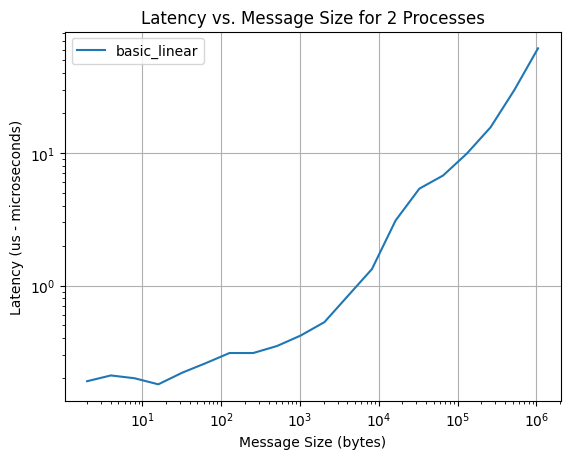

In [9]:
# plotting latency vs. message size for a fixed number of processes (e.g., 2 processes)
for algorithm in df_basic_linear['Algorithm'].unique():
    subset = df_basic_linear[(df_basic_linear['Algorithm'] == algorithm) & (df_basic_linear['Processes'] == 2)]
    plt.plot(subset['Size'], subset['Latency'], label=algorithm)

plt.xlabel('Message Size (bytes)')
plt.ylabel('Latency (us - microseconds)')
plt.title('Latency vs. Message Size for 2 Processes')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

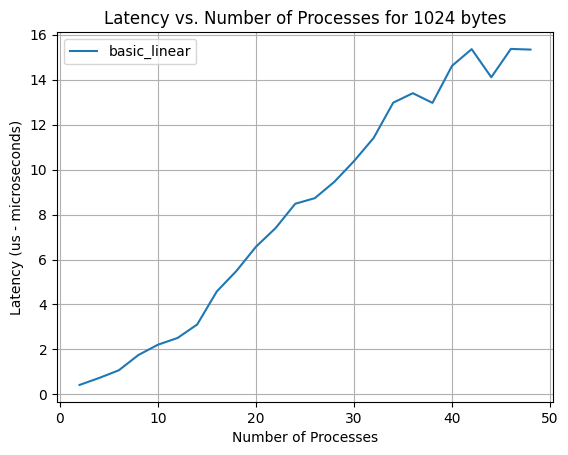

In [10]:
# plotting latency vs. number of processes for a typical message size (e.g., 1024 bytes)
for algorithm in df_basic_linear['Algorithm'].unique():
    subset = df_basic_linear[(df_basic_linear['Algorithm'] == algorithm) & (df_basic_linear['Size'] == 1024)]
    plt.plot(subset['Processes'], subset['Latency'], label=algorithm)

plt.xlabel('Number of Processes')
plt.ylabel('Latency (us - microseconds)')
plt.title('Latency vs. Number of Processes for 1024 bytes')
plt.legend()
plt.grid(True)
plt.show()


To simplify the analysis, we can analyse how each message size contributes to the average by plotting each message size represented by a different line on the same graph. This can be achieved by iterating over each unique message size, calculating the average latency per number of processes for each size, and plotting them together.

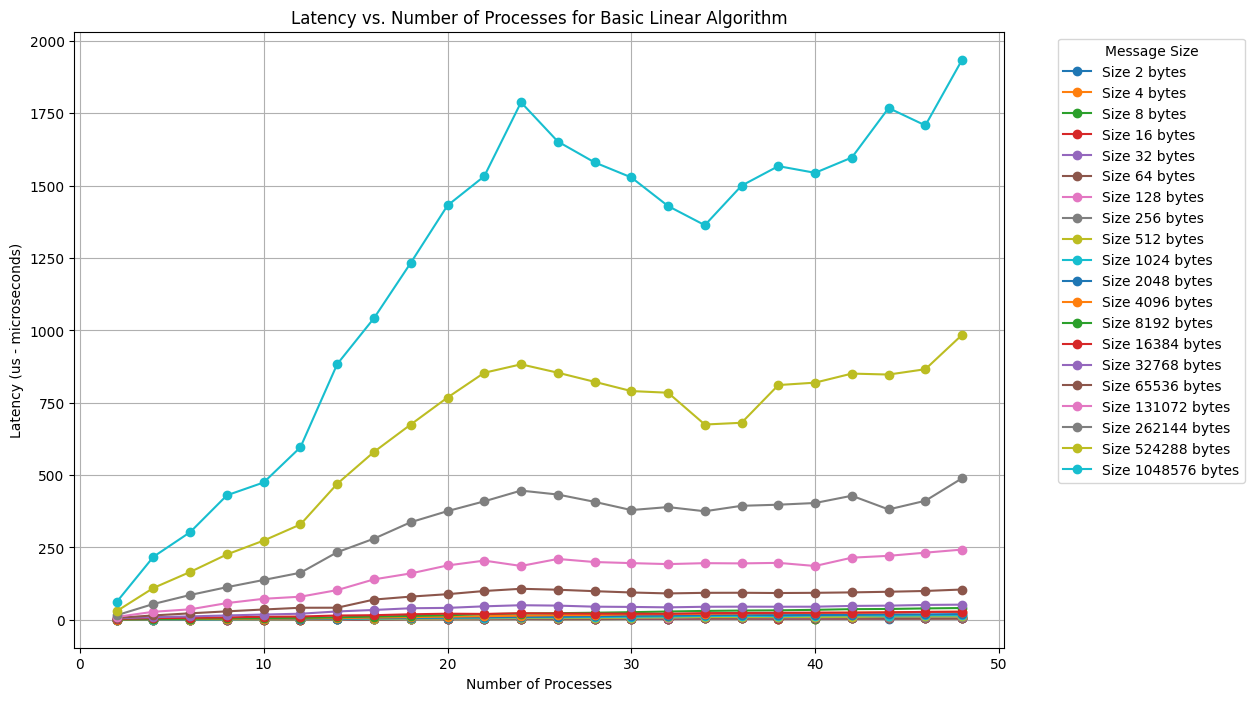

In [11]:
# get unique message sizes
message_sizes = sorted(df_basic_linear['Size'].unique())

# plot each message size with different colors
plt.figure(figsize=(12, 8))

for size in message_sizes:
    subset = df_basic_linear[df_basic_linear['Size'] == size]
    avg_latency = subset.groupby('Processes')['Latency'].mean().reset_index()
    plt.plot(avg_latency['Processes'], avg_latency['Latency'], marker = 'o', linestyle = '-', label = f'Size {size} bytes')

plt.title('Latency vs. Number of Processes for Basic Linear Algorithm')
plt.xlabel('Number of Processes')
plt.ylabel('Latency (us - microseconds)')
plt.legend(title = 'Message Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


From the graph, we can see that the latency for smaller message sizes (up to 256 bytes) show very similar latency patterns, with relatively flat curves as the number of processes increases, indicating good scalability for small messages. As the message size increases, the curves become steeper. For larger message sizes, (262'144 bytes and above), the latency increases more significiantly as the number of processes grows. This suggests a decrease in scalability when handling large messages.

For medium to large message sizes, there is a noticeable increase in latency from 2 to around 20 processes, after which the latency increase the rate appears to become more gradual or even stabilises. There are some peaks and valleys, especially noticeable in the curve for the largest message size, which may indicate points where the system experiences bottlenecks or inefficiencies in communication between processes.

The algorithm seems to scale well with small to medium message sizes, as indicated by the relatively low and stable latencies. There is a clear trend showing that as the message size gets larger, the scalability decreases, with a particularly sharp increase in latency at higher process counts.

## Performance model for broadcast

To infer a performance model for broadcast algorithms on a given HPC architecture, we need to understand the basic mechanisms behind these algorithms and how they interact with the system's hardware.

**Understanding Broadcast Algorithms**:
- Basic Linear: Each process sends data to the next one in a linear chain. It;s simple but can be slow for large messages or many processes because the message is relayed through each process sequentially.
- Chain: Similar to basic linear, but can sens multiple segments of the message simultaneously. It's more efficient than basic linear because it overlaps communication.
- Pipeline: Breaks the message into segments and pipelines them across the processes. It's more efficient for large messages on systems with high bandwidth. 